Импорт библиотек

In [413]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline
plt.style.use('seaborn')

C:\Users\killr\AppData\Local\Temp\ipykernel_10728\3352321590.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Загрузка данных

In [414]:
Sales = pd.read_excel('data\Загрузка продажи.xlsx')
Stocks = pd.read_excel('data\Остатки загрузка.xlsx')
Nomen = pd.read_excel('data\Загрузка справочник.xlsx')

In [415]:
Sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3970 entries, 0 to 3969
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ДАТА        3970 non-null   object 
 1   АРТИКУЛ     3970 non-null   int64  
 2   МЕНЕДЖЕР    3970 non-null   object 
 3   КЛИЕНТ      3970 non-null   object 
 4   ПРОДАЖА ШТ  3970 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 155.2+ KB


In [416]:
Sales.head(2)

,ДАТА,АРТИКУЛ,МЕНЕДЖЕР,КЛИЕНТ,ПРОДАЖА ШТ
0,06.03.2023 г.,101218,Абзалова Ольга Валерьевна,ЧЛ Талгат Айна базар,1.0
1,06.03.2023 г.,101459,Черноиванова Марина,ТОО Magnum Cash&Carry,1200.0


In [417]:
Sales['ДАТА'] = Sales['ДАТА'].apply(lambda x: x[:-3])
Sales['ДАТА'] = pd.to_datetime(Sales['ДАТА'], format='%d.%m.%Y')
Sales.head(2)

,ДАТА,АРТИКУЛ,МЕНЕДЖЕР,КЛИЕНТ,ПРОДАЖА ШТ
0,2023-03-06,101218,Абзалова Ольга Валерьевна,ЧЛ Талгат Айна базар,1.0
1,2023-03-06,101459,Черноиванова Марина,ТОО Magnum Cash&Carry,1200.0


In [418]:
Stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21119 entries, 0 to 21118
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ДАТА     21119 non-null  object 
 1   АРТИКУЛ  21119 non-null  int64  
 2   РАСХОД   21119 non-null  float64
 3   ОСТАТОК  21119 non-null  float64
 4   ЦЕНА     21119 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 825.1+ KB


In [419]:
Stocks.head()

,ДАТА,АРТИКУЛ,РАСХОД,ОСТАТОК,ЦЕНА
0,06.03.2023,100160,0.0,23495.0,3.06
1,06.03.2023,100527,0.0,3800.0,43.70
2,06.03.2023,100701,0.0,14.0,1417.11
3,06.03.2023,101032,0.0,395.0,437.33
4,06.03.2023,101218,1.0,8.0,4710.22


In [420]:
Stocks['ДАТА'] = pd.to_datetime(Stocks['ДАТА'] , format='%d.%m.%Y')
Stocks.head(2)

,ДАТА,АРТИКУЛ,РАСХОД,ОСТАТОК,ЦЕНА
0,2023-03-06,100160,0.0,23495.0,3.06
1,2023-03-06,100527,0.0,3800.0,43.70


In [421]:
Stocks['ДАТА'].min()

Timestamp('2023-03-06 00:00:00')

In [422]:
Nomen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   АРТИКУЛ     456 non-null    int64 
 1   ТОВАР       456 non-null    object
 2   ПРЯМОЙ      456 non-null    int64 
 3   ПОСТАВЩИК   456 non-null    object
 4   АКТИВНОСТЬ  456 non-null    object
 5   АГ          456 non-null    object
 6   НГ          456 non-null    object
dtypes: int64(2), object(5)
memory usage: 25.1+ KB


Создадим таблицу по параметрам артикулов и добавим в нее параметры, связанные с клиентами и статистикой продаж

In [423]:
Nomen['ПОСТАВЩИК'] = Nomen['ПОСТАВЩИК'].apply(lambda x: x[:15])

*Число клиентов*

In [424]:
table = Sales.groupby('АРТИКУЛ')['КЛИЕНТ'].nunique()

In [425]:
Client_count = list(Nomen['АРТИКУЛ'].unique())
Client_count = pd.DataFrame(Client_count, columns=['АРТИКУЛ'])
Client_count['Count'] = Client_count['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.index) else table[x])
Client_count.index = Client_count['АРТИКУЛ']
Client_count = Client_count.drop('АРТИКУЛ', axis=1)

In [426]:
piv_nom = Nomen.copy()
piv_nom['КЛИЕНТОВ'] = piv_nom['АРТИКУЛ'].apply(lambda x: Client_count.loc[x])

*Доля самого крупного клиента*

In [427]:
table = Sales.groupby(['АРТИКУЛ', 'КЛИЕНТ'])['ПРОДАЖА ШТ'].sum().reset_index().sort_values(by=['АРТИКУЛ','ПРОДАЖА ШТ'], ascending=False)
table2 = Sales.groupby(['АРТИКУЛ'])['ПРОДАЖА ШТ'].sum().sort_values(ascending=False).reset_index()
table = pd.merge(left=table, right=table2, on='АРТИКУЛ', how='left')
table['ДОЛЯ'] = table['ПРОДАЖА ШТ_x'] / table['ПРОДАЖА ШТ_y']
table = table.groupby('АРТИКУЛ')['ДОЛЯ'].max()
piv_nom['ДОЛЯ МАКС КЛИЕНТА'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.index) else table.loc[x])
piv_nom.head(2)

,АРТИКУЛ,ТОВАР,ПРЯМОЙ,ПОСТАВЩИК,АКТИВНОСТЬ,АГ,НГ,КЛИЕНТОВ,ДОЛЯ МАКС КЛИЕНТА
0,100084,"Перчатки одноразовые ""Elpi"", размер M, 6 мкм, ...",0,ЭЛПИ-ТРЕЙД ООО,Да,Средства индивидуальной защиты,Перчатки ПЭ стандартной прочности размер M,5,0.598404
1,100160,"Стакан одноразовый 100 мл ""Сп"", прозр., ПП, 10...",0,ПолиЭр ООО,Да,"Стаканы, чашки, крышки для стаканов",Стаканы ПП до 200 мл прозрачные,8,0.258148


*Загрузка средней цены за период*

In [428]:
table = Stocks.groupby('АРТИКУЛ')['ЦЕНА'].median()
piv_nom['ЦЕНА'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table.index) else table.loc[x])
piv_nom.head(2)

,АРТИКУЛ,ТОВАР,ПРЯМОЙ,ПОСТАВЩИК,АКТИВНОСТЬ,АГ,НГ,КЛИЕНТОВ,ДОЛЯ МАКС КЛИЕНТА,ЦЕНА
0,100084,"Перчатки одноразовые ""Elpi"", размер M, 6 мкм, ...",0,ЭЛПИ-ТРЕЙД ООО,Да,Средства индивидуальной защиты,Перчатки ПЭ стандартной прочности размер M,5,0.598404,99.55
1,100160,"Стакан одноразовый 100 мл ""Сп"", прозр., ПП, 10...",0,ПолиЭр ООО,Да,"Стаканы, чашки, крышки для стаканов",Стаканы ПП до 200 мл прозрачные,8,0.258148,3.13


*Вычисление стат параметров стока и продаж*

In [429]:
table = pd.pivot_table(Stocks,values='ОСТАТОК',aggfunc='sum',columns='АРТИКУЛ', index='ДАТА').sort_index()
stock_nulls = table.isnull().mean()
table = table.fillna(0)
table.describe()

АРТИКУЛ,100084,100160,100420,100527,100701,100821,100830,100843,101032,101218,...,451454,451455,451456,451457,451458,451606,451607,505205,591810,591830
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,...,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,268.514706,8019.264706,14.779412,1932.352941,4.941176,847.058824,750.000000,693.382353,242.470588,6.691176,...,2.647059,3.529412,5.294118,1.588235,2.647059,0.176471,0.176471,0.147059,114.838235,28.852941
std,388.804885,5837.949335,19.013621,1519.391195,6.236346,905.121512,1790.313906,480.974168,101.003247,0.850941,...,5.760816,7.681089,11.521633,4.096723,5.760816,0.384054,0.384054,0.525888,22.629798,21.442227
min,0.000000,0.000000,0.000000,380.000000,0.000000,0.000000,0.000000,0.000000,28.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,92.000000,0.000000
25%,0.000000,5295.000000,0.000000,380.000000,0.000000,0.000000,0.000000,475.000000,234.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,92.000000,0.000000
50%,0.000000,8000.000000,0.000000,3380.000000,0.000000,0.000000,0.000000,550.000000,259.500000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,37.000000
75%,425.000000,8000.000000,40.000000,3380.000000,14.000000,1800.000000,0.000000,800.000000,284.000000,7.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,140.000000,37.000000
max,1000.000000,23495.000000,40.000000,3800.000000,14.000000,1800.000000,8000.000000,2400.000000,395.000000,8.000000,...,15.000000,20.000000,30.000000,12.000000,15.000000,1.000000,1.000000,2.000000,140.000000,57.000000


In [430]:
piv_nom = pd.merge(left=piv_nom, right=table.describe().T.reset_index()[['АРТИКУЛ','mean','std','max','50%']], on='АРТИКУЛ', how='left')
piv_nom = piv_nom.rename({'mean':'stocks_mean','std':'stocks_std', 'max':'stocks_max','50%':'stocks_median'}, axis=1)
piv_nom.head(2)

,АРТИКУЛ,ТОВАР,ПРЯМОЙ,ПОСТАВЩИК,АКТИВНОСТЬ,АГ,НГ,КЛИЕНТОВ,ДОЛЯ МАКС КЛИЕНТА,ЦЕНА,stocks_mean,stocks_std,stocks_max,stocks_median
0,100084,"Перчатки одноразовые ""Elpi"", размер M, 6 мкм, ...",0,ЭЛПИ-ТРЕЙД ООО,Да,Средства индивидуальной защиты,Перчатки ПЭ стандартной прочности размер M,5,0.598404,99.55,268.514706,388.804885,1000.0,0.0
1,100160,"Стакан одноразовый 100 мл ""Сп"", прозр., ПП, 10...",0,ПолиЭр ООО,Да,"Стаканы, чашки, крышки для стаканов",Стаканы ПП до 200 мл прозрачные,8,0.258148,3.13,8019.264706,5837.949335,23495.0,8000.0


In [431]:
curr_stock = table.iloc[-1:].T

piv_nom['curr_stock'] = piv_nom['АРТИКУЛ'].apply(lambda x: curr_stock.loc[x].values[0]) 


In [432]:
table2 = pd.pivot_table(Sales,values='ПРОДАЖА ШТ',aggfunc='sum',columns='АРТИКУЛ', index='ДАТА').sort_index()
sales_nulls = table2.isnull().mean()
table2 = table2.fillna(0)
table2.describe()

АРТИКУЛ,100084,100160,100420,100527,100701,100830,100843,101032,101218,101226,...,294016,296140,307971,307973,342045,342047,450743,451423,451457,505205
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,...,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,24.655738,254.016393,0.655738,6.885246,0.229508,98.360656,32.786885,5.360656,0.049180,0.311475,...,3.114754,1.639344,0.852459,0.360656,0.327869,0.622951,0.114754,0.262295,0.196721,0.032787
std,131.321728,838.312203,3.705335,51.236087,1.055043,650.766677,145.454817,14.272389,0.218039,2.432701,...,16.180336,12.803688,3.745380,2.105808,1.795562,3.337484,0.776710,2.048590,1.536443,0.256074
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,901.000000,5000.000000,25.000000,400.000000,6.000000,5000.000000,800.000000,80.000000,1.000000,19.000000,...,90.000000,100.000000,24.000000,15.000000,10.000000,24.000000,6.000000,16.000000,12.000000,2.000000


In [433]:
piv_nom = pd.merge(left=piv_nom, right=table2.describe().T.reset_index()[['АРТИКУЛ','mean','std','max','50%']], on='АРТИКУЛ', how='left')
piv_nom = piv_nom.rename({'mean':'sales_mean','std':'sales_std', 'max':'sales_max','50%':'sales_median'}, axis=1)
piv_nom.head(2)

,АРТИКУЛ,ТОВАР,ПРЯМОЙ,ПОСТАВЩИК,АКТИВНОСТЬ,АГ,НГ,КЛИЕНТОВ,ДОЛЯ МАКС КЛИЕНТА,ЦЕНА,stocks_mean,stocks_std,stocks_max,stocks_median,curr_stock,sales_mean,sales_std,sales_max,sales_median
0,100084,"Перчатки одноразовые ""Elpi"", размер M, 6 мкм, ...",0,ЭЛПИ-ТРЕЙД ООО,Да,Средства индивидуальной защиты,Перчатки ПЭ стандартной прочности размер M,5,0.598404,99.55,268.514706,388.804885,1000.0,0.0,96.0,24.655738,131.321728,901.0,0.0
1,100160,"Стакан одноразовый 100 мл ""Сп"", прозр., ПП, 10...",0,ПолиЭр ООО,Да,"Стаканы, чашки, крышки для стаканов",Стаканы ПП до 200 мл прозрачные,8,0.258148,3.13,8019.264706,5837.949335,23495.0,8000.0,8000.0,254.016393,838.312203,5000.0,0.0


In [434]:
piv_nom = piv_nom.fillna(0)

*Добавим признаки % дней без продаж и без остатков*

In [435]:
piv_nom['sales_nulls'] = piv_nom['АРТИКУЛ'].apply(lambda x: 1 if x not in list(sales_nulls.index) else sales_nulls[x])
piv_nom['stock_nulls'] = piv_nom['АРТИКУЛ'].apply(lambda x: 1 if x not in list(stock_nulls.index) else stock_nulls[x])
piv_nom.head(2)

,АРТИКУЛ,ТОВАР,ПРЯМОЙ,ПОСТАВЩИК,АКТИВНОСТЬ,АГ,НГ,КЛИЕНТОВ,ДОЛЯ МАКС КЛИЕНТА,ЦЕНА,...,stocks_std,stocks_max,stocks_median,curr_stock,sales_mean,sales_std,sales_max,sales_median,sales_nulls,stock_nulls
0,100084,"Перчатки одноразовые ""Elpi"", размер M, 6 мкм, ...",0,ЭЛПИ-ТРЕЙД ООО,Да,Средства индивидуальной защиты,Перчатки ПЭ стандартной прочности размер M,5,0.598404,99.55,...,388.804885,1000.0,0.0,96.0,24.655738,131.321728,901.0,0.0,0.918033,0.529412
1,100160,"Стакан одноразовый 100 мл ""Сп"", прозр., ПП, 10...",0,ПолиЭр ООО,Да,"Стаканы, чашки, крышки для стаканов",Стаканы ПП до 200 мл прозрачные,8,0.258148,3.13,...,5837.949335,23495.0,8000.0,8000.0,254.016393,838.312203,5000.0,0.0,0.852459,0.029412


*Добавим признак симметрии. Рассчитаем его как ковариацию вектора последовательных продаж с вектором линейного роста от минимума к максимуму*

In [436]:
def calc_sym_coef(art, table):
    min_val = table[art].min()
    max_val = table[art].max()
    v = np.linspace(min_val,max_val,table.shape[0])
    w = table[art].values
    v = v - v.mean()
    v = v / np.linalg.norm(v)
    w = w - w.mean()
    if np.linalg.norm(w)<0.0001:
        return 0
    w = w /np.linalg.norm(w)
    return v@w

calc_sym_coef(100084, table2)

0.19793287058644524

In [437]:
piv_nom['stock_sym'] = piv_nom['АРТИКУЛ'].apply(lambda x: calc_sym_coef(x,table))
piv_nom['sales_sym'] = piv_nom['АРТИКУЛ'].apply(lambda x: 0 if x not in list(table2.columns) else calc_sym_coef(x,table2))
piv_nom.head(2)

,АРТИКУЛ,ТОВАР,ПРЯМОЙ,ПОСТАВЩИК,АКТИВНОСТЬ,АГ,НГ,КЛИЕНТОВ,ДОЛЯ МАКС КЛИЕНТА,ЦЕНА,...,stocks_median,curr_stock,sales_mean,sales_std,sales_max,sales_median,sales_nulls,stock_nulls,stock_sym,sales_sym
0,100084,"Перчатки одноразовые ""Elpi"", размер M, 6 мкм, ...",0,ЭЛПИ-ТРЕЙД ООО,Да,Средства индивидуальной защиты,Перчатки ПЭ стандартной прочности размер M,5,0.598404,99.55,...,0.0,96.0,24.655738,131.321728,901.0,0.0,0.918033,0.529412,0.464901,0.197933
1,100160,"Стакан одноразовый 100 мл ""Сп"", прозр., ПП, 10...",0,ПолиЭр ООО,Да,"Стаканы, чашки, крышки для стаканов",Стаканы ПП до 200 мл прозрачные,8,0.258148,3.13,...,8000.0,8000.0,254.016393,838.312203,5000.0,0.0,0.852459,0.029412,-0.458526,0.134252


*Создадим признаки в деньгах*

In [438]:
stat_features_units = ['stocks_mean','stocks_std','stocks_max','stocks_median',
                    'sales_mean', 'sales_std', 'sales_max','sales_median','curr_stock']

for feature in stat_features_units:
    piv_nom[feature+'_$'] = piv_nom[feature] * piv_nom['ЦЕНА']

*Посмотрим на распределения созданных признаков и решим, что их этого логарифмировать*

In [439]:
piv_nom.columns

Index(['АРТИКУЛ', 'ТОВАР', 'ПРЯМОЙ', 'ПОСТАВЩИК', 'АКТИВНОСТЬ', 'АГ', 'НГ',
       'КЛИЕНТОВ', 'ДОЛЯ МАКС КЛИЕНТА', 'ЦЕНА', 'stocks_mean', 'stocks_std',
       'stocks_max', 'stocks_median', 'curr_stock', 'sales_mean', 'sales_std',
       'sales_max', 'sales_median', 'sales_nulls', 'stock_nulls', 'stock_sym',
       'sales_sym', 'stocks_mean_$', 'stocks_std_$', 'stocks_max_$',
       'stocks_median_$', 'sales_mean_$', 'sales_std_$', 'sales_max_$',
       'sales_median_$', 'curr_stock_$'],
      dtype='object')

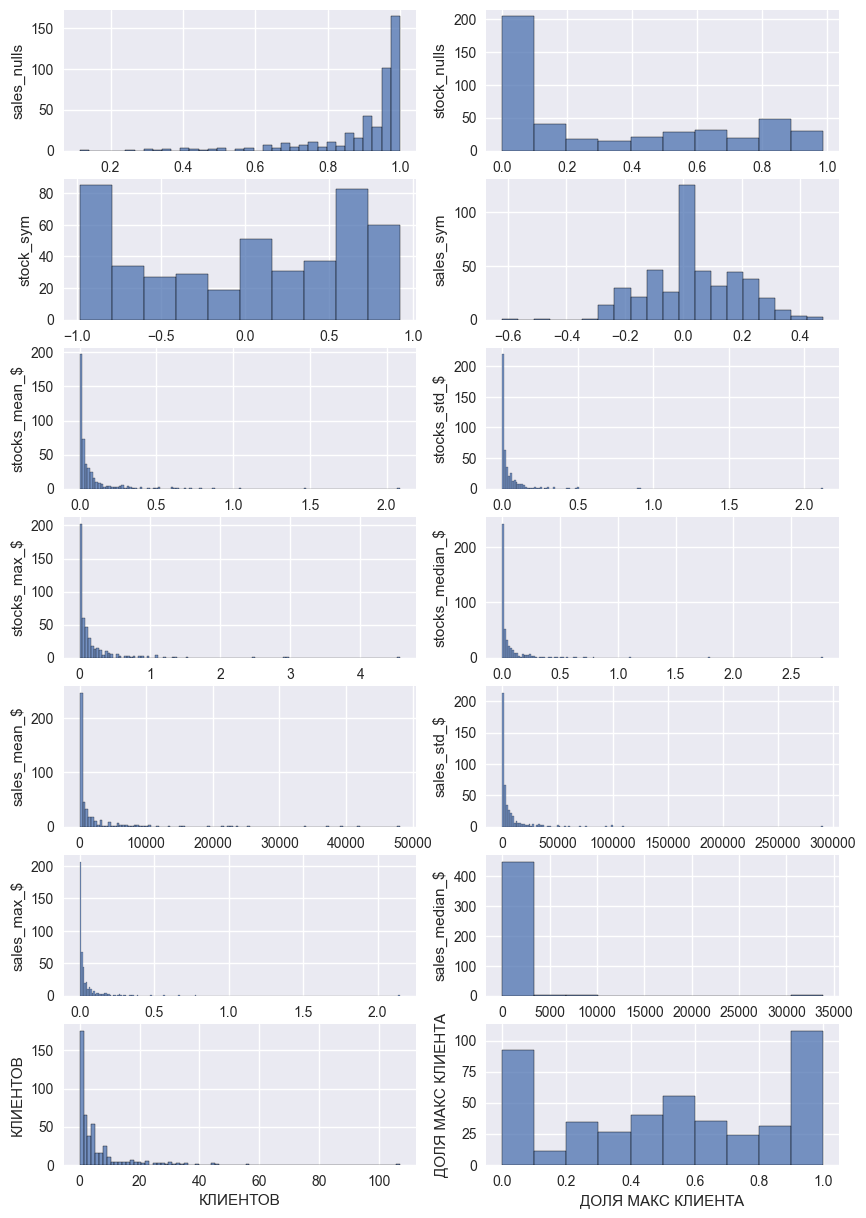

In [440]:
features = ['sales_nulls', 'stock_nulls', 'stock_sym', 'sales_sym',
       'stocks_mean_$', 'stocks_std_$', 'stocks_max_$', 'stocks_median_$',
       'sales_mean_$', 'sales_std_$', 'sales_max_$', 'sales_median_$','КЛИЕНТОВ', 'ДОЛЯ МАКС КЛИЕНТА']

fig, axes = plt.subplots(len(features)//2,2, figsize = [10,15])
for i,feature in enumerate(features):
    sns.histplot(piv_nom[feature], ax= axes[i//2][i%2])
    axes[i//2][i%2].set_ylabel(feature)

In [441]:
features_to_log = ['stocks_mean_$', 'stocks_std_$', 'stocks_max_$', 'stocks_median_$',
       'sales_mean_$', 'sales_std_$', 'sales_max_$', 'sales_median_$','КЛИЕНТОВ']

for feature in features_to_log:
    piv_nom[feature+'_log'] = piv_nom[feature].apply(lambda x: np.log(x+1))
    
piv_nom.columns

Index(['АРТИКУЛ', 'ТОВАР', 'ПРЯМОЙ', 'ПОСТАВЩИК', 'АКТИВНОСТЬ', 'АГ', 'НГ',
       'КЛИЕНТОВ', 'ДОЛЯ МАКС КЛИЕНТА', 'ЦЕНА', 'stocks_mean', 'stocks_std',
       'stocks_max', 'stocks_median', 'curr_stock', 'sales_mean', 'sales_std',
       'sales_max', 'sales_median', 'sales_nulls', 'stock_nulls', 'stock_sym',
       'sales_sym', 'stocks_mean_$', 'stocks_std_$', 'stocks_max_$',
       'stocks_median_$', 'sales_mean_$', 'sales_std_$', 'sales_max_$',
       'sales_median_$', 'curr_stock_$', 'stocks_mean_$_log',
       'stocks_std_$_log', 'stocks_max_$_log', 'stocks_median_$_log',
       'sales_mean_$_log', 'sales_std_$_log', 'sales_max_$_log',
       'sales_median_$_log', 'КЛИЕНТОВ_log'],
      dtype='object')

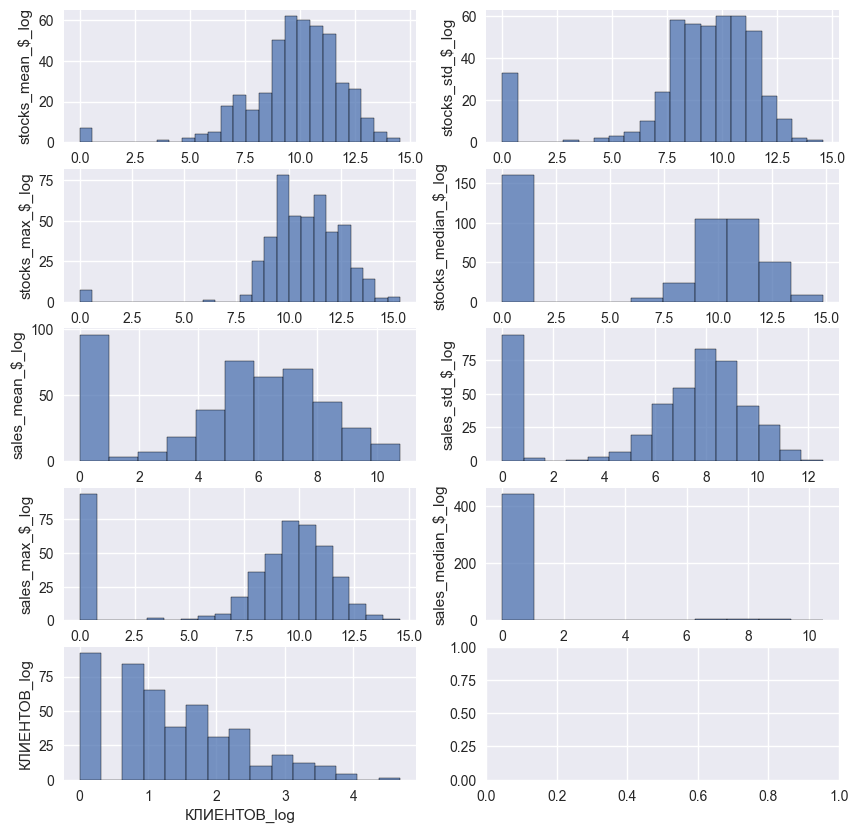

In [442]:
features = ['stocks_mean_$_log', 'stocks_std_$_log', 'stocks_max_$_log',
       'stocks_median_$_log', 'sales_mean_$_log', 'sales_std_$_log',
       'sales_max_$_log', 'sales_median_$_log', 'КЛИЕНТОВ_log']

fig, axes = plt.subplots(len(features)//2+1,2, figsize = [10,10])
for i,feature in enumerate(features):
    sns.histplot(piv_nom[feature], ax= axes[i//2][i%2])
    axes[i//2][i%2].set_ylabel(feature)

***Отбор признаков для кластеризации***

<AxesSubplot: >

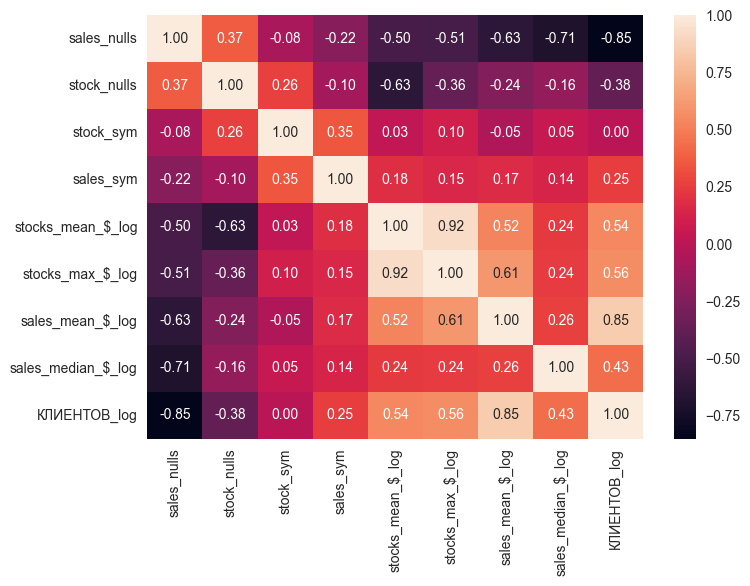

In [443]:
features = ['sales_nulls', 'stock_nulls', 'stock_sym', 'sales_sym',
       'stocks_mean_$_log', 'stocks_max_$_log', 'sales_mean_$_log', 'sales_median_$_log', 'КЛИЕНТОВ_log']

clust_data = piv_nom[features]
sns.heatmap(clust_data.corr(), annot=True, fmt='.2f')

In [444]:
clust_data.isnull().sum()

sales_nulls           0
stock_nulls           0
stock_sym             0
sales_sym             0
stocks_mean_$_log     0
stocks_max_$_log      0
sales_mean_$_log      0
sales_median_$_log    0
КЛИЕНТОВ_log          0
dtype: int64

*Нормализуем данные*

In [445]:

scaler = MinMaxScaler()
clust_data = scaler.fit_transform(clust_data)

*Теперь попробуем проинтерпретировать результат. Посмотрим на общий вид графиков каждого кластера*

In [446]:
from sklearn.cluster import AgglomerativeClustering

params = list()
for i in range(3,10):
    agc = AgglomerativeClustering(n_clusters=i)
    clusters = agc.fit_predict(clust_data)
    params.append([i,silhouette_score(clust_data,clusters)])
    
params = pd.DataFrame(params, columns=['K','silhouette'])
params.sort_values('silhouette', ascending=False)

,K,silhouette
4,7,0.322717
3,6,0.316822
6,9,0.315619
5,8,0.300461
2,5,0.293754
1,4,0.279008
0,3,0.255081


0    28.947368
2    18.421053
4    15.789474
3    15.350877
1    12.719298
6     5.482456
5     3.289474
dtype: float64

<AxesSubplot: ylabel='cluster'>

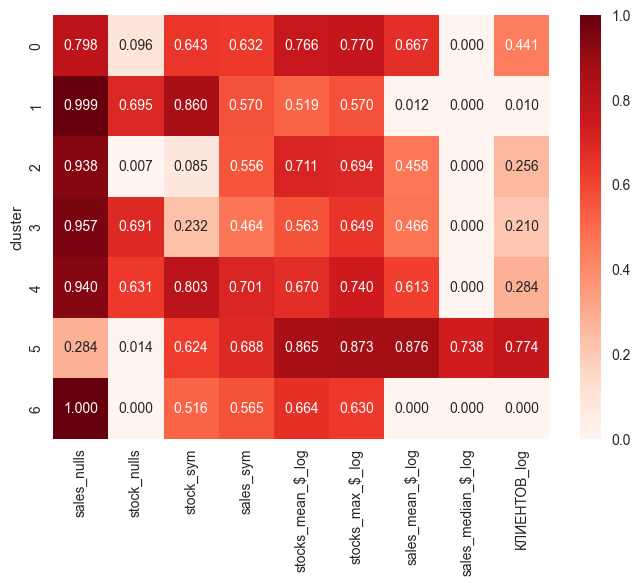

In [447]:
agc = AgglomerativeClustering(n_clusters=7)
agc.fit(clust_data)
display(pd.Series(agc.labels_).value_counts().sort_values(ascending=False)/pd.Series(agc.labels_).value_counts().sum()*100)

agc_df = pd.DataFrame(clust_data, columns=features)
agc_df['cluster'] = agc.labels_

sns.heatmap(agc_df.groupby('cluster').mean(), annot=True, fmt='.3f', cmap='Reds')

In [448]:
piv_nom['cluster'] = agc.labels_

* 0 - регулярные
* 1 - плохие новинки
* 2 - опасные
* 3 - под заказ
* 4 - хорошие новинки
* 5 - ядерные
* 6 - висяки

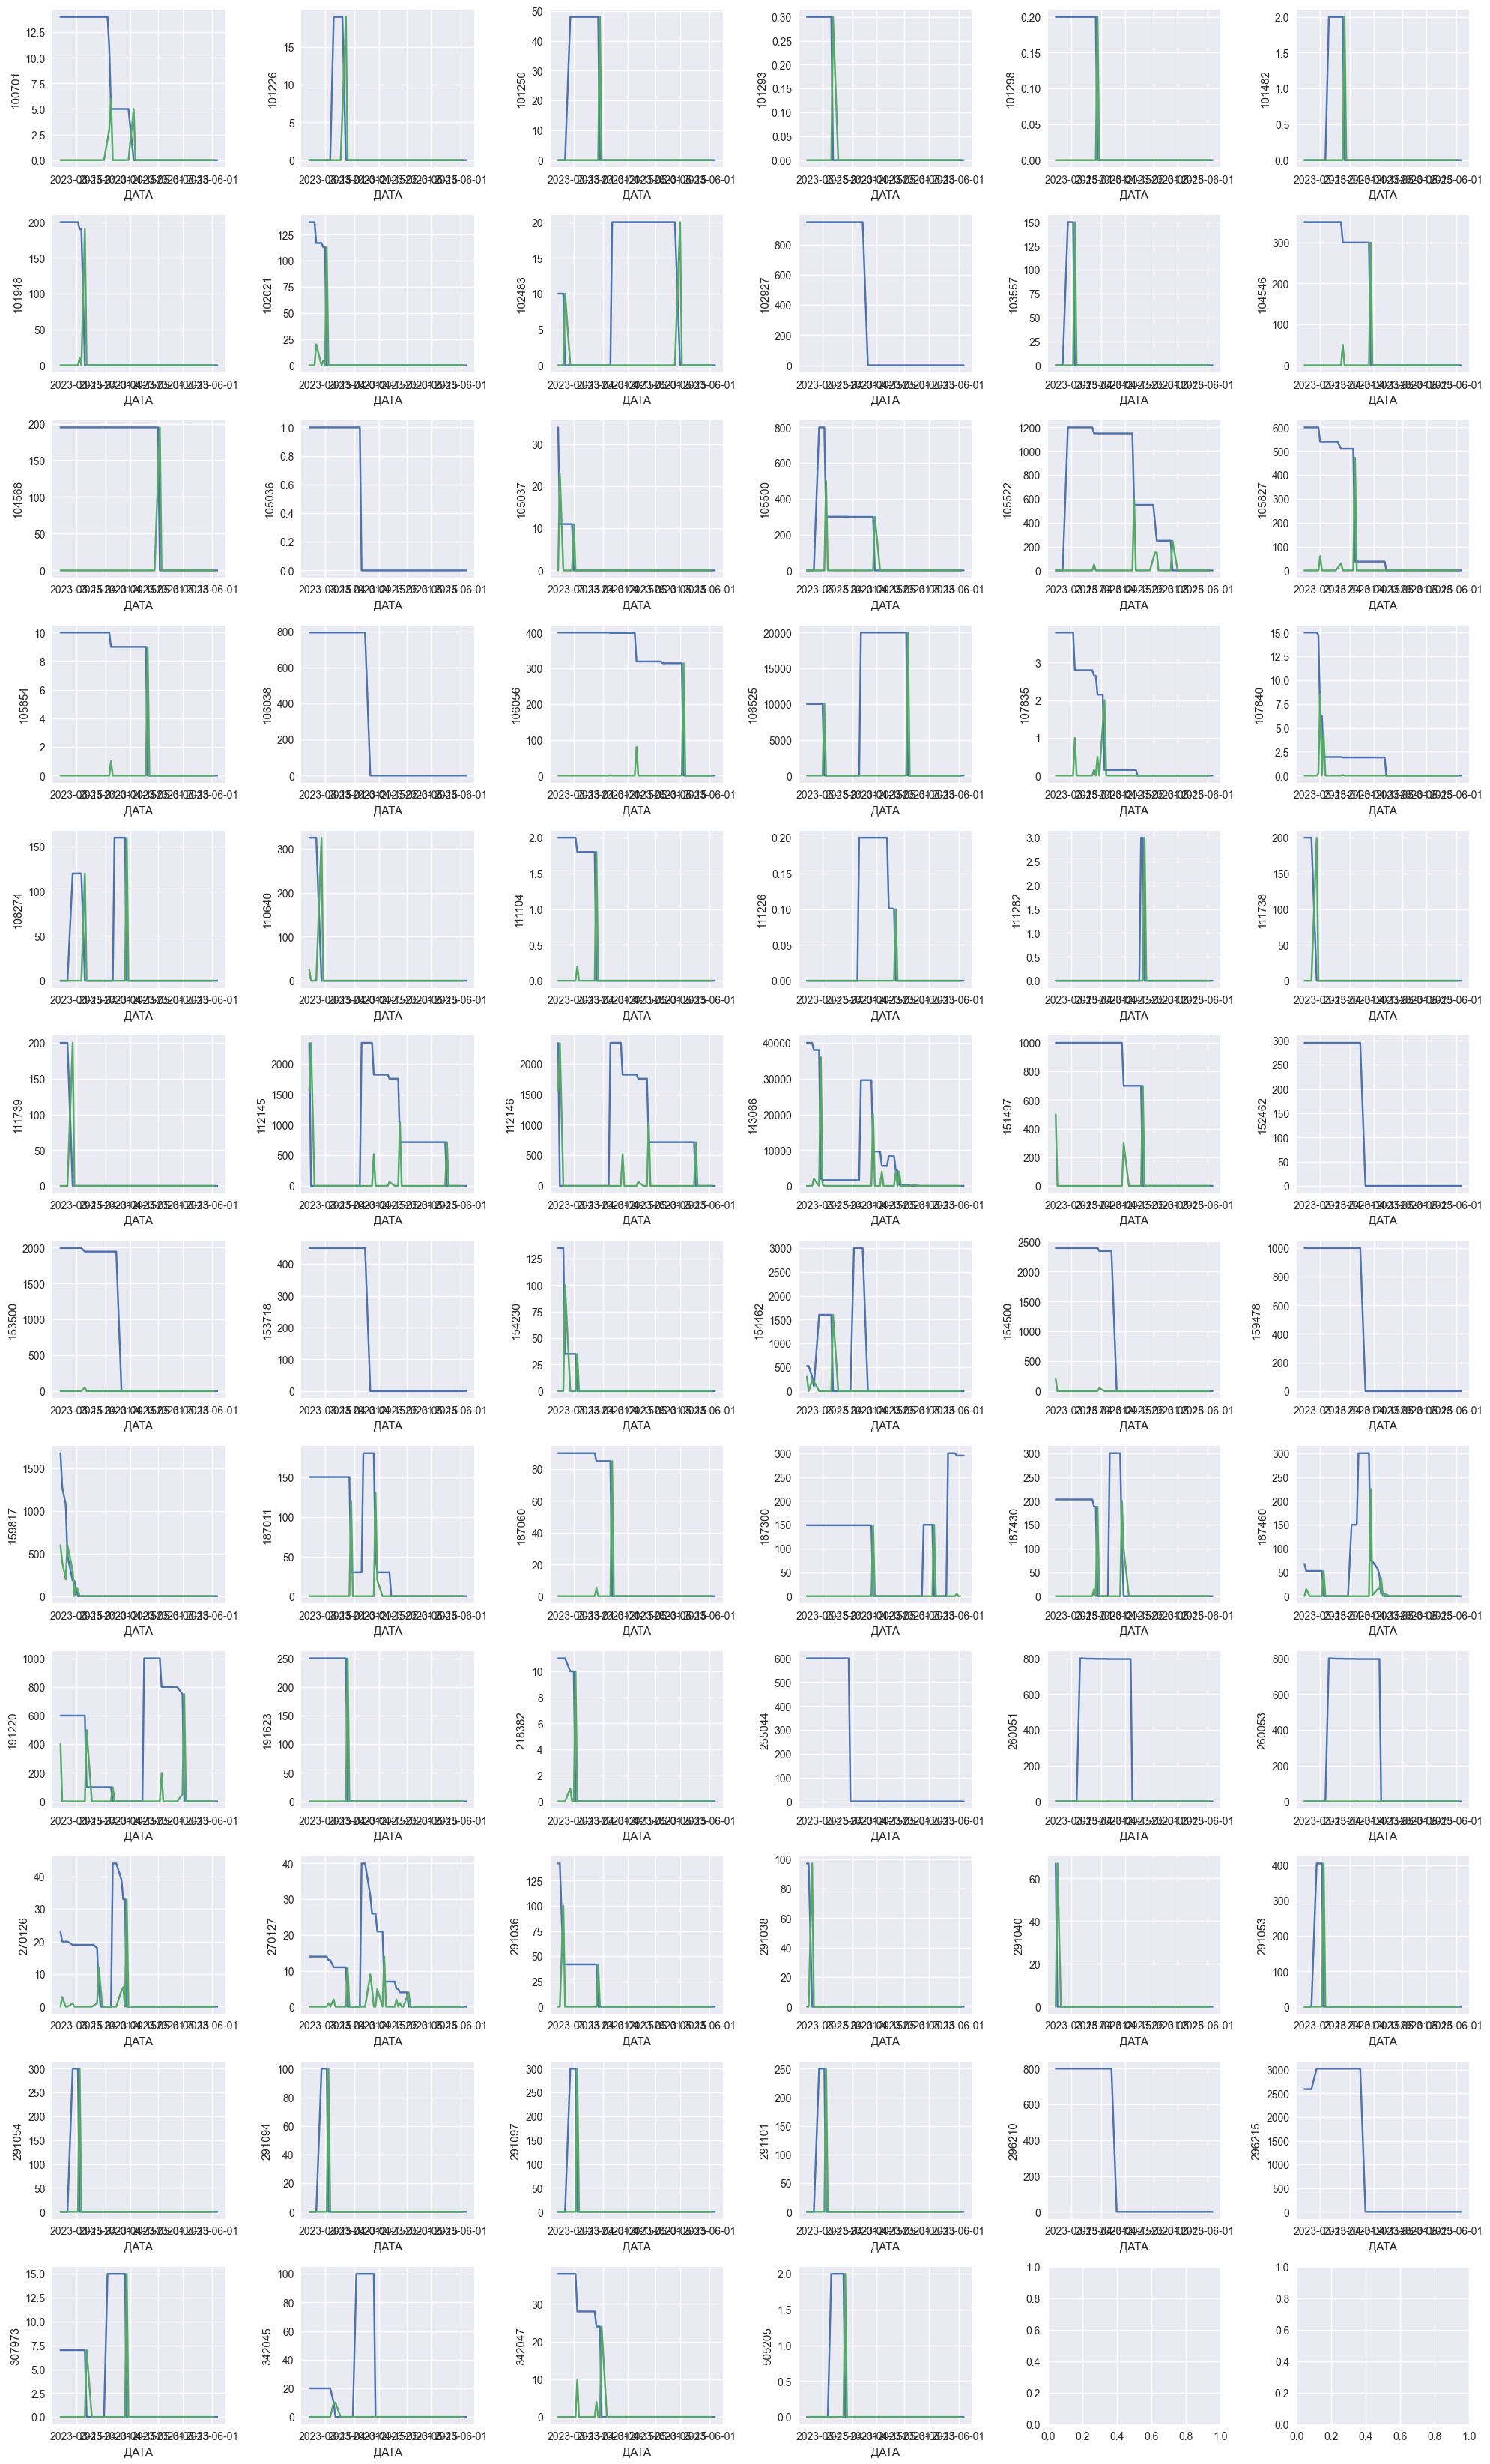

In [460]:
#Кластер 0
cluster = list(piv_nom[piv_nom['cluster']==3]['АРТИКУЛ'])

fig, axes = plt.subplots(len(cluster)//6+1,6, figsize = [20,len(cluster)//6*3])
for i,art in enumerate(cluster):
    if art in list(table.columns):
        sns.lineplot(table[art].T, ax=axes[i//6][i%6])
    if art in list(table2.columns):    
        sns.lineplot(table2[art].T, ax=axes[i//6][i%6])
fig.set_label('Графики продаж/остатков по группе артикулов')       
plt.tight_layout()


*Присвоение имен кластеров*

1. Sales_median_$_log -> max, это ядерная группа
2. sales_nulls -> min - это группа регулярных
3. Sales_mean = КЛИЕНТОВ -> 0 - это висяки
4. Sales_mean = КЛИЕНТОВ -> min - это плохие новинки
5. Stock_nulls -> min - опасные
6. Stock_sym -> max - хорошие новинки
7. Оставшееся - под заказ

In [450]:
name_selection = agc_df.groupby('cluster').mean().reset_index()
kernal_cluster = name_selection.sort_values(by='sales_median_$_log',ascending=False).index[0]
name_selection =name_selection.drop(kernal_cluster, axis=0)

regular_cluster = name_selection.sort_values(by='sales_nulls',ascending=True).index[0]
name_selection =name_selection.drop(regular_cluster, axis=0)

nomove_cluster = name_selection.sort_values(by='sales_mean_$_log',ascending=True).index[0]
name_selection =name_selection.drop(nomove_cluster, axis=0)

badnov_cluster = name_selection.sort_values(by='sales_mean_$_log',ascending=True).index[0]
name_selection =name_selection.drop(badnov_cluster, axis=0)

danger_cluster = name_selection.sort_values(by='stock_nulls',ascending=True).index[0]
name_selection = name_selection.drop(danger_cluster, axis=0)

goodnov_cluster =  name_selection.sort_values(by='stock_sym',ascending=False).index[0]
name_selection = name_selection.drop(goodnov_cluster, axis=0)

fororder_cluster = name_selection.sort_values(by='stock_sym',ascending=False).index[0]

clust_diсt = {
    kernal_cluster: 'Ядерные',
    regular_cluster: 'Регулярные',
    nomove_cluster: 'Висяки',
    badnov_cluster: 'Плохие новинки',
    danger_cluster: 'Опасные',
    goodnov_cluster: 'Хорошие новинки',
    fororder_cluster: 'Под заказ'
}

piv_nom['cluster_name'] = piv_nom['cluster'].apply(lambda x: clust_diсt[x])


Визуализация результатов кластеризации

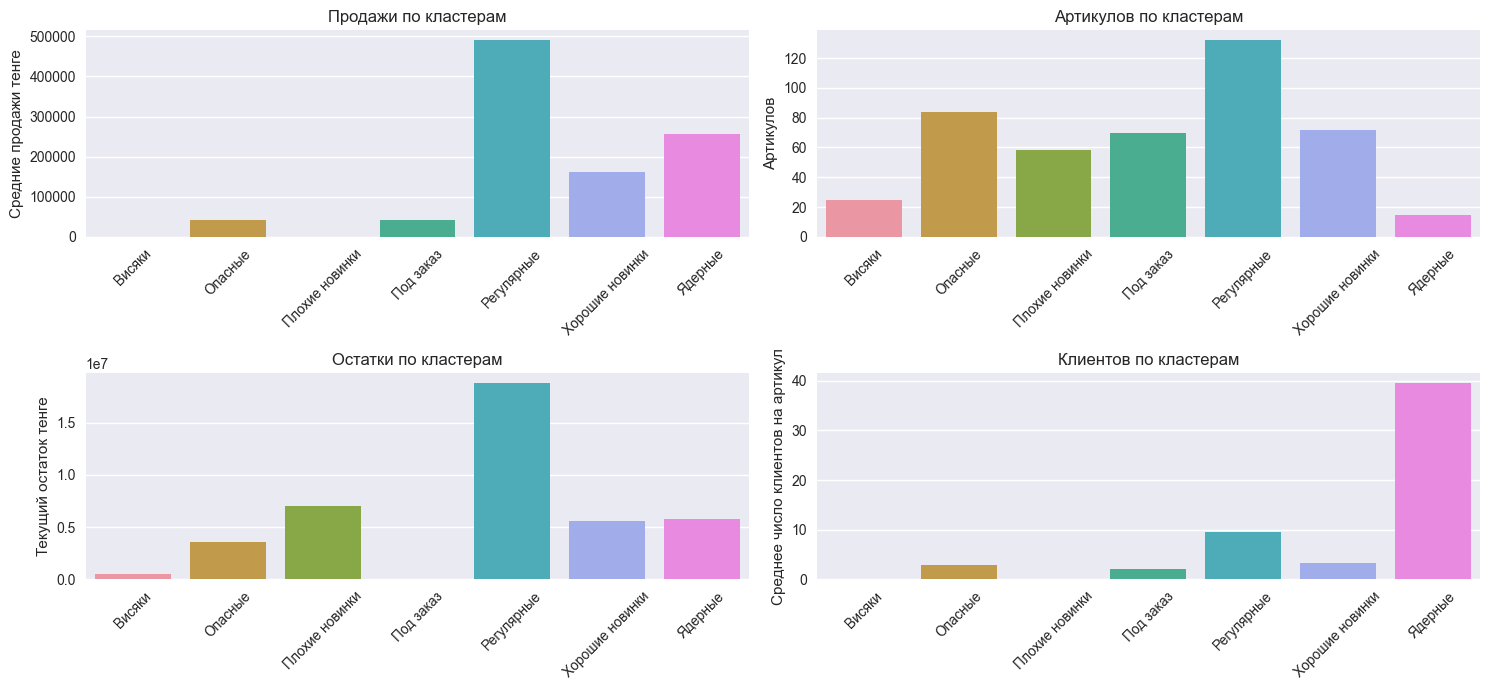

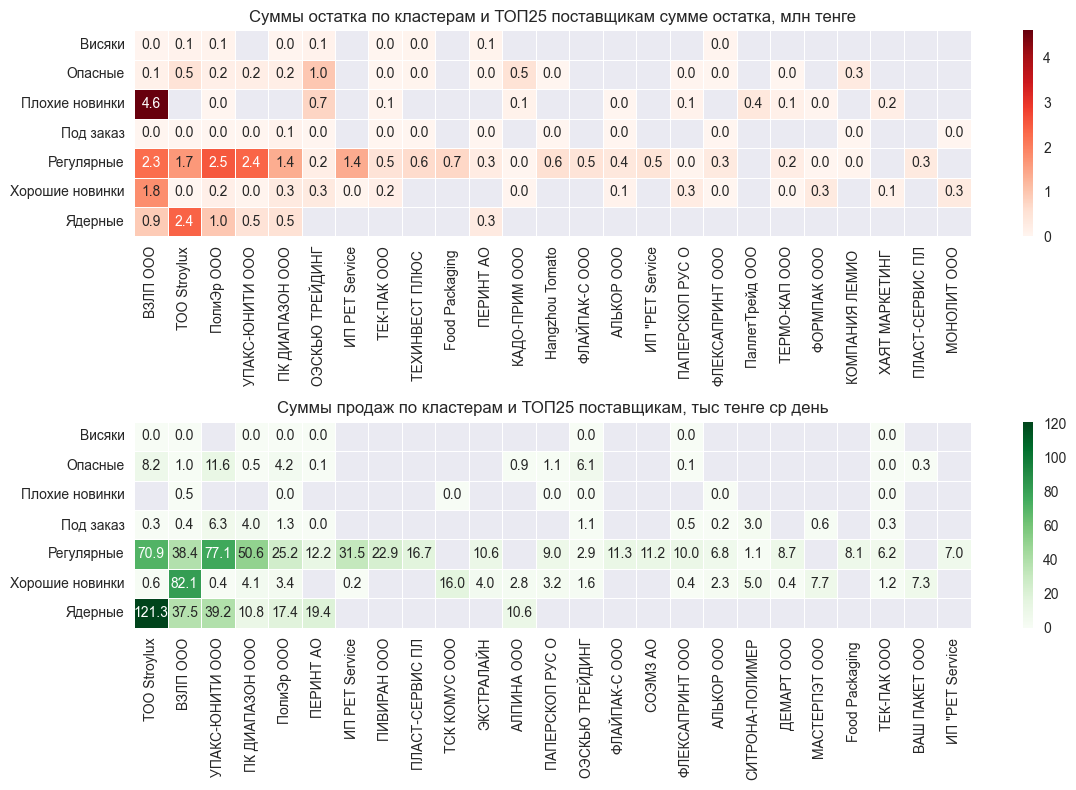

In [455]:
fig, axes = plt.subplots(2,2,figsize=[15,7])

table3 = piv_nom.groupby('cluster_name')['sales_mean_$'].sum()
bar1 = sns.barplot( x=table3.index, y=table3.values, ax=axes[0][0])
bar1.axes.set_ylabel('Средние продажи тенге')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Продажи по кластерам')


table3 = piv_nom.groupby('cluster_name')['АРТИКУЛ'].nunique()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[0][1])
bar1.axes.set_ylabel('Артикулов')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Артикулов по кластерам')

table3 = piv_nom.groupby('cluster_name')['curr_stock_$'].sum()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[1][0])
bar1.axes.set_ylabel('Текущий остаток тенге')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Остатки по кластерам')

table3 = piv_nom.groupby('cluster_name')['КЛИЕНТОВ'].mean()
bar1 = sns.barplot(x=table3.index, y=table3.values,ax=axes[1][1])
bar1.axes.set_ylabel('Среднее число клиентов на артикул')
bar1.axes.set_xlabel('')
bar1.xaxis.set_tick_params(rotation=45)
bar1.set_title('Клиентов по кластерам')
plt.tight_layout()

fig, axes = plt.subplots(2,1,figsize=[12,8])

max_stock_suppliers = piv_nom.groupby('ПОСТАВЩИК')['curr_stock_$'].sum().sort_values(ascending=False).iloc[:25]
table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='ПОСТАВЩИК', values='curr_stock_$', aggfunc='sum')
table3 = table3 /1000000

heat = sns.heatmap(table3[list(max_stock_suppliers.index)],  cmap='Reds',linewidth=.5, annot=True, fmt='.1f', ax=axes[0])
heat.set_title('Суммы остатка по кластерам и ТОП25 поставщикам сумме остатка, млн тенге')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')

max_stock_suppliers = piv_nom.groupby('ПОСТАВЩИК')['sales_mean_$'].sum().sort_values(ascending=False).iloc[:25]
table3 = pd.pivot_table(data=piv_nom, index='cluster_name', columns='ПОСТАВЩИК', values='sales_mean_$', aggfunc='sum')
table3 = table3 /1000

heat = sns.heatmap(table3[list(max_stock_suppliers.index)],  cmap='Greens',linewidth=.5, annot=True, fmt='.1f', ax=axes[1])
heat.set_title('Суммы продаж по кластерам и ТОП25 поставщикам, тыс тенге ср день')
heat.axes.set_ylabel('')
heat.axes.set_xlabel('')
plt.tight_layout()

Визуализация по конкретному артикулу

In [452]:
#art =152462

#ig, ax = plt.subplots(1,1, figsize = [8,3])
#sns.lineplot(table[art].T, ax=ax)
#sns.lineplot(table2[art].T, ax=ax)
#line = pd.DataFrame(table[art].T.copy())

#mean_level = table2.describe().T.loc[101032]['mean']
#std_level = mean_level + table2.describe().T.loc[101032]['std']

#line['mean'] = mean_level
#№line['std'] = std_level
#line
#sns.lineplot(line['mean'], ax=ax)
#sns.lineplot(line['std'], ax=ax)


In [453]:
Stocks[Stocks['АРТИКУЛ'] == art]

,ДАТА,АРТИКУЛ,РАСХОД,ОСТАТОК,ЦЕНА
234,2023-03-06,254501,500.0,1995.0,22.74
498,2023-03-07,254501,500.0,1495.0,22.74
764,2023-03-09,254501,200.0,1295.0,22.74
1028,2023-03-10,254501,300.0,995.0,22.74
1310,2023-03-13,254501,0.0,12995.0,22.74
...,...,...,...,...,...
19650,2023-05-30,254501,0.0,2095.0,21.66
20001,2023-05-31,254501,400.0,1695.0,21.66
20352,2023-06-01,254501,1600.0,95.0,21.66
20712,2023-06-02,254501,0.0,7895.0,21.66
